In [408]:
import csv
import matplotlib.pyplot as plt
import numpy as np


# CSV einlesen

In [446]:
with open('https://raw.githubusercontent.com/Yannik26/pdp_a03_schraube/65eca527162368976a202a23feae909dea3934b1/KraefteFederDaempferSpule.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    Fts=np.array([])
    Fk=np.array([])
    Fd=np.array([])
    time=np.array([])
    for row in csv_reader:
        if line_count == 0:
            names=row
            line_count += 1
        else:
            Fts=np.append(Fts,float(row[3]))
            Fk=np.append(Fk,float(row[1]))
            time=np.append(time,float(row[0]))
            Fd=np.append(Fd,float(row[2]))
            line_count += 1
    print(f'Processed {line_count} lines.')
Fk/=3
Fd/=3
Fges=Fk+Fd


Processed 19002 lines.


# Sicherheitsfaktor

In [410]:
Smin=5

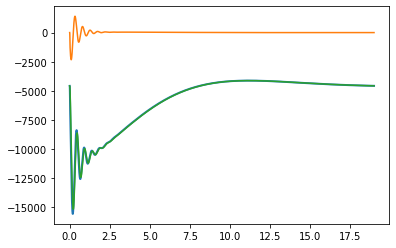

In [411]:
fig,ax= plt.subplots()
ax.plot(time,Fges,linewidth=2, label='Fges')
ax.plot(time,Fd,label='Fd')
ax.plot(time,Fk,label='Fk')
plt.show()

# Belastungsanalyse
## Maximale Kraft auf Schrauben im Flansch

In [412]:
Fmax=Fges.max()
Fmin=Fges.min()
print(f'Maximaler Wert: {Fmax} N')
print(f'Minimaler Wert: {Fmin} N')

if abs(Fmax)>=abs(Fmin):
    Fa_flansch=Fmax
else:
    Fa_flansch=Fmin
print(f'Fa_flansch: {Fa_flansch} N')

Maximaler Wert: -4123.798180368143 N
Minimaler Wert: -15566.97064153368 N
Fa_flansch: -15566.97064153368 N


## Zugbelastung pro Schraube

In [413]:
N=6  #Anzahl der Schrauben pro Flansch
Fa=np.abs(Fa_flansch/N)
print(f'Kraft pro Schraube: {Fa} N')
print(f'Maximale Kraft mit Sicherheit:{Fa * Smin}')

Kraft pro Schraube: 2594.4951069222802 N
Maximale Kraft mit Sicherheit:12972.475534611402


# Vorauslegung
Fm_min und Fm_max aus Tabelle aus VDI 2230

In [414]:
X=12    #Erster Anteil der Festigkeitsangabe X.Y
Y=9     #Zweiter Anteil der Festigkeitsangabe X.Y
Fm_min=40000
Fm_max=63000
RmS=X*100
Rp02S=RmS*Y/10

## Gewindedaten

In [415]:
# Toleranzen: Mutter 6g, Schraube 6H  --> Standard
d=12
d_min=11.701
s=8    #Schlüsselweite
P=1.75
d1=9.853
d1_min=9.602
d2=10.863
d2_min=10.679
d3=9.583   # Kerndurchmesser
RmM=1100
D1=10.106
D1_min=10.106
D1_max=10.441
D2=10.863
D2_max=11.036
As=np.pi*((d1+d2)/4)**2
beta_M=0.65       #Scherspannungsfaktor
beta_S=0.6        # VDI 2230 Blatt 1 Tabelle 7 Seite 104
tau_bM=720
tau_bS=RmS*beta_S

dw=18      # Außendurchmesser Kopfauflagefläche
dh=13.5     #Mittlerer Bohrungsdurchmesser "Durchgangsbohrung für metrische Schrauben"
s=18             # Schlüsselweite in mm

## Festigkeitsverhältnis

In [416]:
Rs=(RmM/RmS)*( ( d*( P/2+( d-D2 )* np.tan(np.radians(30))))  /  (D1*(P/2+(d2-D1)*np.tan(np.radians(30)))) )
print(f'Rs={Rs}')
if Rs>=1:
    print('Das Außengewinde ist kritisch')
elif Rs<1:
    print('Das Innengewinde ist kritisch')

        

Rs=1.2704678364801452
Das Außengewinde ist kritisch


## Korrekturfaktoren

In [417]:
C1=1

if 1<Rs<2.2:
    C2=5.594-13.682*Rs+14.107*Rs**2-6.057*Rs**3+0.9353*Rs**4 
elif Rs>=2.2:
    C2=1.187
        

if 0.4<Rs<1:
    C3=0.728+1.769*Rs-2.896*Rs**2+1.296*Rs**3
elif Rs<=0.4:
    Rs=0.4
    C3=0.728+1.769*Rs-2.896*Rs**2+1.296*Rs**3
elif Rs>=1:
    C3=0.897

        

print(f'C1={C1}') 
print(f'C2={C2}') 
print(f'C3={C3}')

C1=1
C2=0.9973536576658124
C3=0.897


In [418]:
if  Rs>=1:
    m_ges=(1.2*RmM*As*P)/((C1*C2*tau_bS*(P/2+(d2_min-D1_max)*np.tan(np.radians(30))))*np.pi*d)+2*P
elif Rs<1:
    m_ges=(1.2*RmS*As*P)/((C1*C3*tau_bM*(P/2+(d_min-D2_max)*np.tan(np.radians(30))))*np.pi*d)+2*P
print(f'm_ges={m_ges} mm')

m_ges=10.60206628432158 mm


In [419]:
lk=10
lmin=m_ges+lk
print(f'lmin={lmin} mm')
l=26

lmin=20.60206628432158 mm


# Nachgiebigkeiten und Kraftverhältnisse
## Ersatzfläche

In [420]:

DA=2*s

Ep=205000  # E-Modul Platte
Es=210000  # E-Modul Schraube

if DA<=dw:
    Aers=np.pi/4*(DA**2-dh**2)
elif dw<DA<=dw+lk:
    x=(lk/DA)**0.2
    Aers=np.pi/4*(dw**2-dh**2)+np.pi/8*dw*(DA-dw)*((x+1)**2-1)
elif DA>dw+lk:
    x=(lk/(dw+lk))**0.2
    Aers=np.pi/4*(dw**2-dh**2)+np.pi/8*dw*lk*(DA-dw)*((x+1)**2-1)
    
print(f'Aers={Aers} mm^2')

Aers=3025.2740553360436 mm^2


## Nachgiebigkeit Platte

In [421]:
delta_p=lk/(Aers*Ep)
print(f'Nachgiebigkeit der Platte: delta_p={delta_p}')

Nachgiebigkeit der Platte: delta_p=1.612432028061655e-08


## Nachgiebigkeit Schraube

In [422]:
l1=0     #Nur Gewinde auf Schraube, da zu kurz für Schaft
l3=lk-l1
lG=l-lk
d1_schaft=10
delta_SK=(0.5*d)/(np.pi/4*d**2*Es)
delta_1=l1/(np.pi/4*d1_schaft**2*Es)
delta_3=l3/(np.pi/4*d3**2*Es)
delta_G=(0.5*d)/(np.pi/4*d3**2*Es)
delta_m=(0.33*d)/(np.pi/4*d**2*Ep)
delta_s=delta_SK+delta_1+delta_3+delta_G+delta_m
print(f'delta_s={delta_s}')

delta_s=1.4797773049879634e-06


## Krafteinleitungsfaktor

In [423]:
n=0.3

## Kraftverhältnisse
### Vorspannkraftverlust infolge Setzens 𝑭_z

In [424]:
fz=(3+2.5+2*1.5)*10**-3     # in mm
Fz=fz/(delta_s+delta_p)
print(f'Fz={Fz} N')

Fz=5682.1918342884865 N


### Nachgiebigkeitsverhältnis

In [425]:
phi=delta_p/(delta_s+delta_p)
print(f'phi={phi}')

phi=0.010778997768467247


### Schraubenzusatzkraft

In [426]:
FSA=Fa*n*phi
print(f'Fa={Fa} N')
print(f'FSA={FSA} N')

Fa=2594.4951069222802 N
FSA=8.389817090344334 N


### Hülsenentlastungskraft

In [427]:
FPA=Fa*(1-n*phi)
print(f'FPA={FPA} N')

FPA=2586.105289831936 N


### Min. Montagevorspannkraft

In [428]:
Fkerf=0
FMmin=Fkerf+FPA+Fz
print(f'FMmin={FMmin} N')

FMmin=8268.297124120421 N


### Vorspannkraft nach dem Setzen

In [429]:
Fv=FMmin-Fz
print(f'Fv={Fv} N')

Fv=2586.105289831935 N


## Verspannungsdiagramm nach Rötscher
### Schraubenlängung fsm durch FMmin

In [430]:
fsm=delta_s*FMmin
print(f'fsm={fsm} mm')
print(f'FMmin={FMmin} N')

fsm=0.012235238435170645 mm
FMmin=8268.297124120421 N


### Plattenverkürzung fpm durch FMmin

In [431]:
fpm=delta_p*FMmin
print(f'fpm={fpm} mm')

fpm=0.0001333206710046184 mm


### Schraubenlängung fs durch Fv

In [432]:
fs=delta_s*Fv
print(f'fs={fs} mm')

fs=0.0038268599162026165 mm


### Plattenverkürzung fp durch Fv

In [433]:
fp=delta_p*Fv

print(f'fp={fp} mm')

fp=4.1699189972646814e-05 mm


### Schraubenlängung dfs durch Fa

In [434]:
dfs=delta_s*FSA
print(f'dfs={dfs}')

dfs=1.2415060923291694e-05


### Plattenverkürzung dfp durch Fa

In [435]:
dfp=delta_p*FPA
print(f'dfp={dfp}')

dfp=4.169918997264683e-05


# Wirkende Montagebeanspruchung
## Maximale Montagevorspannkraft

In [436]:
alpha_A=1.6        # Steifes Bauteil, wenige Versuche, Skript Seite 342 Tabelle 8.4
FMmax=alpha_A*FMmin
print(f'FMmax={FMmax} N')

FMmax=13229.275398592676 N


## Max. Vorspannkraft und Vergleichsspannung
### Zugspannung

In [437]:
sigma_zM=FMmax/As
print(f'Zugspannung sigma_zM={sigma_zM} MPa')

Zugspannung sigma_zM=156.99808774507713 MPa


### Torsionsspannung

In [438]:
my_g=0.12      #Reibungszahl im Gewinde
ds=2*np.sqrt(As/np.pi)
MG=FMmax*d2/2*(P/(np.pi*d2)+1.155*my_g)
Wp=np.pi*ds**3
tau_M=MG/Wp
print(f'Torsionsspannung tau_M={tau_M} MPa')

Torsionsspannung tau_M=3.908002866245148 MPa


### Gestaltänderungsenergiehypothese

In [439]:
sigma_vM=np.sqrt(sigma_zM**2+3*tau_M**2)
print(f'Vergleichsspannung nach GEH: sigma_vM={sigma_vM} MPa')

Vergleichsspannung nach GEH: sigma_vM=157.14393725123054 MPa


# Zulässige Montagebeanspruchung
## Zulässige Zugspannung

In [440]:
ny=0.9          # In Norm wird 0.9 verwendet
sigma_vzul=ny*Rp02S
if sigma_vM<sigma_vzul/Smin:
    print('Die Schraube erträgt die Montagebeanspruchung unter den getroffenen Annahmen!')
else:
    print('Bitte Schraube neu auslegen!!!')

print(sigma_vM/sigma_vzul)
print(f'Sicherheit: S={sigma_vzul/sigma_vM}')

Die Schraube erträgt die Montagebeanspruchung unter den getroffenen Annahmen!
0.16167071733665694
Sicherheit: S=6.185412030538828


##  Maximal zulässige Montagevorspannkraft

In [444]:
#sigma_zzul=sigma_vzul/(Smin*np.sqrt(1+3*(2*d2/d1_min*(P/(np.pi*d2)+1.155*my_g))**2))
sigma_zzul=Rp02S/(Smin*np.sqrt(1+3*(2*d2/d1_min*(P/(np.pi*d2)+1.155*my_g))**2))
FMzul=sigma_zzul*As
if FMmax<FMzul:
    print('Die Schraube erträgt die Montagebeanspruchung unter den getroffenen Annahmen!')
else:
    print('Bitte Schraube neu auslegen!!!')
print(FMmax/FMzul)
print(f'Sicherheit: S={(FMzul*Smin)/FMmax}')

Die Schraube erträgt die Montagebeanspruchung unter den getroffenen Annahmen!
0.9060050787839661
Sicherheit: S=5.518732860428295


# Wirkende Betriebsbeanspruchungen
## Max. Schraubenkraft und Vergleichsspannung

In [442]:
kappa_tau=0.5
FSmax=FMmax+FSA
sigma_B=FSmax/As
tau_B=kappa_tau*MG/Wp
sigma_vB=np.sqrt(sigma_B**2+3*tau_B**2)
print(f'sigma_vB={sigma_vB} MPa')

sigma_vB=157.1341056490851 MPa


# Zulässige Betriebsbeanspruchungen

In [443]:
if sigma_vB<Rp02S/Smin:
    print('Die Schraube erträgt die angenommene Betriebsbeanspruchung')
    print(f'Sicherheit S={Rp02S/sigma_vB}')

Die Schraube erträgt die angenommene Betriebsbeanspruchung
Sicherheit S=6.873110045325722
